In [ ]:
!git clone https://github.com/geyuying/PF-AFN.git

Cloning into 'PF-AFN'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 383 (delta 74), reused 118 (delta 35), pack-reused 197
Receiving objects: 100% (383/383), 4.49 MiB | 13.04 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
%cd PF-AFN
%cd PF-AFN_test

/content/PF-AFN
/content/PF-AFN/PF-AFN_test


In [ ]:
!pip install git+https://github.com/tommy19970714/Pytorch-Correlation-extension.git@support-operator

  Cloning https://github.com/tommy19970714/Pytorch-Correlation-extension.git (to revision support-operator) to /tmp/pip-req-build-w50xu4je
  Running command git clone -q https://github.com/tommy19970714/Pytorch-Correlation-extension.git /tmp/pip-req-build-w50xu4je
  Running command git checkout -b support-operator --track origin/support-operator
  Switched to a new branch 'support-operator'
  Branch 'support-operator' set up to track remote branch 'support-operator' from 'origin'.
  Created wheel for spatial-correlation-sampler: filename=spatial_correlation_sampler-0.3.0-cp37-cp37m-linux_x86_64.whl size=3165210 sha256=127a699fe2a4b32c19b47e22aeba7fe7ab1ea0e9a21b809483fca660c983d8fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-nc_lrf4u/wheels/84/c1/c0/397e3ede95a8df8bf8ff91328fa257d0013eb28d69337c0441
Successfully built spatial-correlation-sampler


# Model Download

In [ ]:
# download model from google drive
# https://drive.google.com/file/d/16g2gALbUEc_hwndQ0DCQzj8bdOMy1QLm/view?usp=sharing
!gdown --id 16g2gALbUEc_hwndQ0DCQzj8bdOMy1QLm

Downloading...
From: https://drive.google.com/uc?id=16g2gALbUEc_hwndQ0DCQzj8bdOMy1QLm
To: /content/PF-AFN/PF-AFN_test/gen_model.pt
176MB [00:01, 144MB/s]


In [ ]:
# download model from google drive
# https://drive.google.com/file/d/1DqlQu5tEHFbsdv2J1CehULblWRlsrjcF/view?usp=sharing
!gdown --id 1DqlQu5tEHFbsdv2J1CehULblWRlsrjcF

Downloading...
From: https://drive.google.com/uc?id=1DqlQu5tEHFbsdv2J1CehULblWRlsrjcF
To: /content/PF-AFN/PF-AFN_test/warp_model.pt
118MB [00:01, 92.7MB/s]


# Data

In [ ]:
import random
import numpy as np
from PIL import Image

def get_params(size):
    w, h = size
    new_h = h
    new_w = w

    x = random.randint(0, np.maximum(0, new_w - 512))
    y = random.randint(0, np.maximum(0, new_h - 512))

    flip = 0
    return {'crop_pos': (x, y), 'flip': flip}

In [ ]:
def __scale_width(img, target_width, method=Image.BICUBIC):
    ow, oh = img.size
    if (ow == target_width):
        return img    
    w = target_width
    h = int(target_width * oh / ow)    
    return img.resize((w, h), method)

In [ ]:
import torchvision.transforms as transforms
def get_transform(params, method=Image.BICUBIC, normalize=True):
    loadSize = 512
    fineSize = 512
    transform_list = []
    transform_list.append(transforms.Lambda(lambda img: __scale_width(img, loadSize, method)))
    osize = [256,192]
    transform_list.append(transforms.Scale(osize, method))  
    transform_list += [transforms.ToTensor()]

    if normalize:
        transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

# RUN

In [ ]:
person_image_path = "dataset/test_img/000066_0.jpg"
I = Image.open(person_image_path).convert('RGB')

params = get_params(I.size)
transform = get_transform(params)
transform_E = get_transform(params, method=Image.NEAREST, normalize=False)

I_tensor = transform(I).unsqueeze(0)

clothes_image_path = "dataset/test_clothes/003434_1.jpg"
C = Image.open(clothes_image_path).convert('RGB')
C_tensor = transform(C).unsqueeze(0)

cloth_edge_path = "dataset/test_edge/003434_1.jpg"
E = Image.open(cloth_edge_path).convert('L')
E_tensor = transform_E(E).unsqueeze(0)

data = { 'image': I_tensor,'clothes': C_tensor, 'edge': E_tensor}

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
!pip show spatial_correlation_sampler

Name: spatial-correlation-sampler
Version: 0.3.0
Summary: Correlation module for pytorch
Home-page: https://github.com/ClementPinard/Pytorch-Correlation-extension
Author: Clément Pinard
Author-email: clement.pinard@ensta-paristech.fr
License: UNKNOWN
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, torch
Required-by: 


In [ ]:
import torch

In [ ]:
# torch.ops.load_library("/usr/local/lib/python3.7/dist-packages/spatial_correlation_sampler_backend.cpython-37m-x86_64-linux-gnu.so")

In [ ]:
warp_model = torch.jit.load("warp_model.pt")
gen_model = torch.jit.load("gen_model.pt")

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [ ]:
optimized_warp_model = optimize_for_mobile(warp_model)
optimized_warp_model._save_for_lite_interpreter("warp_model.ptl")

In [ ]:
optimized_gen_model = optimize_for_mobile(gen_model)
optimized_gen_model._save_for_lite_interpreter("gen_model.ptl")

In [ ]:
import torch.nn.functional as F
import cv2

In [ ]:
real_image = data['image']
clothes = data['clothes']

edge = data['edge']
edge = torch.FloatTensor((edge.detach().numpy() > 0.5).astype(np.int))
clothes = clothes * edge

flow_out = warp_model(real_image.cpu(), clothes.cpu())
warped_cloth, last_flow, = flow_out
warped_edge = F.grid_sample(edge.cpu(), last_flow.permute(0, 2, 3, 1),
                mode='bilinear', padding_mode='zeros')

gen_inputs = torch.cat([real_image.cpu(), warped_cloth, warped_edge], 1)
gen_outputs = gen_model(gen_inputs)
p_rendered, m_composite = torch.split(gen_outputs, [3, 1], 1)
p_rendered = torch.tanh(p_rendered)
m_composite = torch.sigmoid(m_composite)
m_composite = m_composite * warped_edge
p_tryon = warped_cloth * m_composite + p_rendered * (1 - m_composite)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [ ]:
a = real_image.float().cpu()
b= clothes.cpu()
c = p_tryon
combine = torch.cat([a[0],b[0],c[0]], 2).squeeze()
cv_img=(combine.permute(1,2,0).detach().cpu().numpy()+1)/2
output=(cv_img*255).astype(np.uint8)

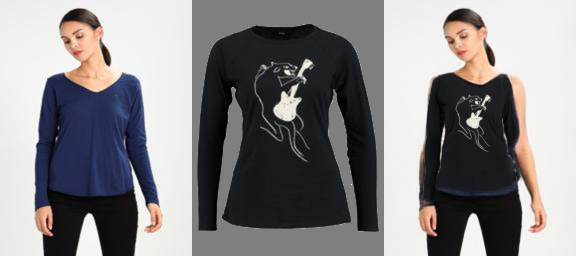

In [ ]:
Image.fromarray(output)